In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np
from matplotlib import pyplot as plt
from art.classifiers import TensorflowV2Classifier
from art.attacks import FastGradientMethod, CarliniLInfMethod

In [2]:
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires Tensorflow v2.')

# Load MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_test = x_test[0:100]
y_test = y_test[0:100]

In [4]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [5]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [6]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

# Tensorflow with custom class

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [8]:
class KerasModel(Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.conv1 = Conv2D(filters=3, kernel_size=3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

In [9]:
model = KerasModel()

In [10]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [11]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [12]:
epochs = 1

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.30, Accuracy: 91.65, Test Loss: 0.11, Test Accuracy: 94.00


In [13]:
y_test_pred = np.argmax(model(x_test), axis=1)
accuracy_test = np.sum(y_test_pred == y_test) / y_test.shape[0]
print('Test accuracy:', accuracy_test)

Test accuracy: 0.94


In [14]:
classifier = TensorflowV2Classifier(model=model, nb_classes=10, loss_object=loss_object, clip_values=(0, 1), 
                                    channel_index=3)

In [15]:
attack_fgsm = FastGradientMethod(classifier=classifier)

In [16]:
x_test_adv = attack_fgsm.generate(x_test)

In [17]:
y_test_pred = np.argmax(model(x_test_adv), axis=1)
test_accuracy_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
l_inf_distance = np.mean(np.abs((x_test_adv - x_test)))
print('Test accuracy:', test_accuracy_adv)
print('L_Inf average distance:', l_inf_distance)

Test accuracy: 0.04
L_Inf average distance: 0.17509092


In [18]:
x_test_adv.shape

(100, 28, 28, 1)

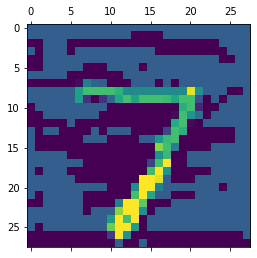

In [19]:
plt.matshow(x_test_adv[0, :, :, 0])
plt.show()

In [20]:
attack_cw = CarliniLInfMethod(classifier=classifier, eps=0.3, max_iter=100, learning_rate=0.01)

In [21]:
x_test_adv = attack_cw.generate(x_test)

In [22]:
y_test_pred = np.argmax(model(x_test_adv), axis=1)
test_accuracy_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
l_inf_distance = np.mean(np.abs((x_test_adv - x_test)))
print('Test accuracy:', test_accuracy_adv)
print('L_Inf average distance:', l_inf_distance)

Test accuracy: 0.23
L_Inf average distance: 0.029111082


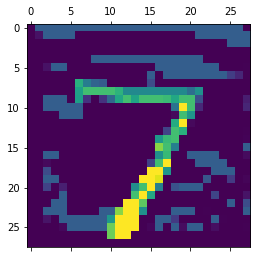

In [23]:
plt.matshow(x_test_adv[0, :, :, 0])
plt.show()

# Tensorflow with custom function

In [24]:
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((100, 784))

In [25]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [26]:
W = tf.Variable(initial_value=tf.random.normal(shape=(784, 10)), name="W")
b = tf.Variable(tf.zeros(shape=(10)), name="b")

In [27]:
@tf.function
def forward(x):
    x = tf.matmul(x, W) + b
    denominator = tf.expand_dims(tf.reduce_sum(tf.exp(x), axis=1), axis=1)
    softmax = (1.0 / denominator) * tf.exp(x)
    return softmax

In [28]:
x = forward(x_test[0:2])

In [29]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = forward(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))

    train_loss(loss)
    train_accuracy(labels, predictions)

In [30]:
@tf.function
def test_step(images, labels):
    predictions = forward(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [31]:
epochs = 1

for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))

Epoch 1, Loss: 0.88, Accuracy: 82.60, Test Loss: 0.47, Test Accuracy: 90.00


In [32]:
y_test_pred = np.argmax(forward(x_test), axis=1)
accuracy_test = np.sum(y_test_pred == y_test) / y_test.shape[0]
print('Test accuracy:', accuracy_test)

Test accuracy: 0.86


In [33]:
classifier = TensorflowV2Classifier(model=forward, nb_classes=10, loss_object=loss_object, clip_values=(0, 1), 
                                    channel_index=3)

In [34]:
attack_fgsm = FastGradientMethod(classifier=classifier)

In [35]:
x_test_adv = attack_fgsm.generate(x_test)

In [36]:
y_test_pred = np.argmax(forward(x_test_adv), axis=1)
test_accuracy_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
l_inf_distance = np.mean(np.abs((x_test_adv - x_test)))
print('Test accuracy: {:4.2f}'.format(test_accuracy_adv))
print('L_Inf average distance: {:4.2f}'.format(l_inf_distance))

Test accuracy: 0.13
L_Inf average distance: 0.15


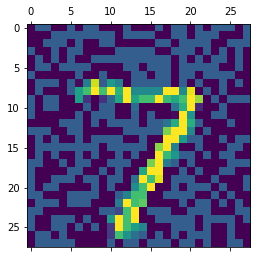

In [37]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.show()

In [38]:
attack_cw = CarliniLInfMethod(classifier=classifier, eps=0.3, max_iter=100, learning_rate=0.01)

In [39]:
x_test_adv = attack_cw.generate(x_test)

In [40]:
y_test_pred = np.argmax(forward(x_test_adv), axis=1)
test_accuracy_adv = np.sum(y_test_pred == y_test) / y_test.shape[0]
l_inf_distance = np.mean(np.abs((x_test_adv - x_test)))
print('Test accuracy: {:4.2f}'.format(test_accuracy_adv))
print('L_Inf average distance: {:4.2f}'.format(l_inf_distance))

Test accuracy: 0.37
L_Inf average distance: 0.01


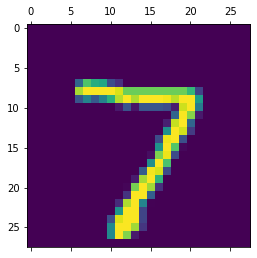

In [41]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.show()